In [165]:
import os

from collections import defaultdict
import gzip

import matplotlib.pyplot as plt
import numpy as np

import venn

In [151]:
# This two file need to be downloaded from https://ftp.ncbi.nih.gov/gene/DATA/
gene_ensemble_file = '../../ncbi_data/gene2ensembl'
gene_info_file = '/home/xzyao/ncbi_data/gene_info.gz'

ensemble_to_entrez = {}
with open(gene_ensemble_file) as f:
    for line in f:
        l = line.strip().split('\t')
        
        if l[0] != '9606':
            continue
        
        entrez = l[1]
        
        ensemble = l[-1].split('.')[0]
        
        ensemble_to_entrez[ensemble] = entrez


In [152]:
# read gene_info.gz
entrez_to_symbol = {}
symbol_to_entrez = {}
with gzip.open(gene_info_file, 'r') as f:
    f.readline()
    for line in f:
        l = line.decode('utf-8').strip().split('\t')

        tax_id = l[0]
        if tax_id != '9606':
            continue
        entrez = l[1]
        symbol = l[2]

        entrez_to_symbol[entrez] = symbol
        symbol_to_entrez[symbol] = entrez


In [153]:
# read DISEASE file
# This three file need to be downloaded form https://diseases.jensenlab.org/Downloads

experiments_file = '../data/DISEASES_data/human_disease_experiments_full.tsv'

knowledge_file = '../data/DISEASES_data/human_disease_knowledge_full.tsv'

textmining_file = '../data/DISEASES_data/human_disease_textmining_filtered.tsv'


def read_benchmark(benchmark_file: str, ensemble_entrez_dict: dict,\
                   disease_idx: str, \
                   #sig_gene_set: set
                  ):
    
    
    gene_dis_pair_set = set()
    related_gene_set = set()
    
    miss_gene_set = set()
    with open(benchmark_file) as f:
        for line in f:
            l = line.strip().split('\t')
            
            # ensemble id
            gene_id = l[0]
            
            gene_symbol = l[1]
            
            # ICD10 ID
            disease_id = l[2]
            
            if disease_id == disease_idx:
                
                if not ensemble_entrez_dict.get(gene_id):
                    miss_gene_set.add(gene_symbol)
                    continue
                
                entrez = ensemble_entrez_dict[gene_id]
                
                gene_dis_pair_set.add((entrez, disease_id))
                related_gene_set.add(entrez)
    
    print(f'Total {len(gene_dis_pair_set):,} Gene-Disease pairs.')
    return related_gene_set


In [154]:
def MRR_calculate(top_n_list: list, benchmark_set: set):
    # https://towardsdatascience.com/ranking-evaluation-metrics-for-recommender-systems-263d0a66ef54
    
    Q = len(benchmark_set)
    R = 0
    
    target_count = 0
    for gene in benchmark_set:
        
        if gene in top_n_list:
            target_count += 1
            rank = top_n_list.index(gene) + 1

            R += 1 / rank
        else:
            R += 0

    return R/Q
    

In [155]:
def hit_calculate(top_n_list: list, benchmark_set: set, topn: int):
    # https://stackoverflow.com/questions/58796367/how-is-hitsk-calculated-and-what-does-it-mean-in-the-context-of-link-prediction
    total_hit = 0
    hit_count = 0
    for idx, gene in enumerate(top_n_list):
        if gene in benchmark_set:
            total_hit += 1
            
            if idx < topn:
                hit_count += 1
                
    return hit_count / total_hit
    

In [156]:
def precision_recall_calculate(top_n_list: list, benchmark_set, topn='all'):
    
    if topn == 'all':
        topn = len(top_n_list)
    
    total_hit = 0
    for idx, gene in enumerate(top_n_list):
        if gene in benchmark_set and idx < topn:
            total_hit += 1
        
        if idx > topn:
            break
        
    
    return total_hit / topn, total_hit/ len(benchmark_set)
    
    

In [157]:
def read_symbol_entrez_p_file(symbol_entrez_p_file: str, top_n=None):
    
    entrez_to_p = {}
    entrez_to_symbol = {}
    with open(symbol_entrez_p_file) as f:
        for line in f:
            symbol, entrez, p = line.strip().split('\t')
            p = float(p)
            
            entrez_to_p[entrez] = p
            entrez_to_symbol[entrez] = symbol
            
    entrez_sorted = sorted(entrez_to_p, key=lambda x: entrez_to_p[x])
    if top_n is None:
        return entrez_to_p, entrez_to_symbol, entrez_sorted
    else:
        new_entrez_to_p = {entrez: {entrez_to_p[entrez]} for entrez in entrez_sorted[:top_n]}
        return new_entrez_to_p, entrez_to_symbol, entrez_sorted[:top_n]

In [243]:
# Comparison of EMFAS results and DISEASES

# report file
ensembel_file = 'type the report file'

# top-n gene for visualization
top_n = 50

entrez_hpo_count = {}
with open(ensembel_file) as f:
    f.readline()
    for line in f:
        l = line.strip().split('\t')
        
        entrez = l[0]
        symbol = l[1]
        
        tag_count = int(l[-1])
        
        sent_count = int(l[13])
        
        entrez_hpo_count[entrez] = tag_count
   
top_gene_list = sorted(entrez_hpo_count, key=lambda x: entrez_hpo_count[x], reverse=True)[:top_n]

top_gene_set = set(top_gene_list)

print(f'top gene list: {len(top_gene_list):,}')

top gene list: 3,288


In [244]:
# 取出 AD的 GWAS基因
alzheimer_file = 'type your symbol-entrez-p file.'

gwas_top_n = None

entrez_to_p, entrez_to_symbol, gwas_top_entrez_list = read_symbol_entrez_p_file(alzheimer_file, gwas_top_n)

print(f'GWAS genes: {len(gwas_top_entrez_list):,}')

GWAS genes: 17,894


In [245]:
# 读取DISEASES数据库
# DOID:10652	Alzheimer's disease
dis_id = 'Type your Disease id, it can be found in DISEASES database. like: Alzheimer\' s disease is DOIS:10652'

print('Experiments:')
experiments_gene_set= read_benchmark(experiments_file,ensemble_to_entrez, dis_id)
print('Knowledge:')
knowledge_gene_set = read_benchmark(knowledge_file, ensemble_to_entrez, dis_id)
print('text mining:')
textmining_gene_set = read_benchmark(textmining_file, ensemble_to_entrez, dis_id)

total_benchmark_gene_set = experiments_gene_set|knowledge_gene_set|textmining_gene_set
print(f'total benchmark gene: {len(total_benchmark_gene_set)}')

Experiments:
Total 317 Gene-Disease pairs.
Knowledge:
Total 26 Gene-Disease pairs.
text mining:
Total 290 Gene-Disease pairs.
total benchmark gene: 578


In [246]:
# 统计EMFAS结果的y
top_n_plot = 50

count_emfas = 0
y_emfas = []

count_gwas = 0
y_gwas = []
for i in range(top_n_plot):
    if top_gene_list[i] in total_benchmark_gene_set:
        count_emfas += 1
        #count_emfas = 1
        #print('hit')
    #print(count_emfas)
    y_emfas.append(count_emfas)
    
    if gwas_top_entrez_list[i] in total_benchmark_gene_set:
        count_gwas += 1
    y_gwas.append(count_gwas)


In [247]:
# type your fig save path.
fig_save_path = 'type your fig save path'
if not os.path.exists(fig_save_path):
    os.mkdir(fig_save_path)

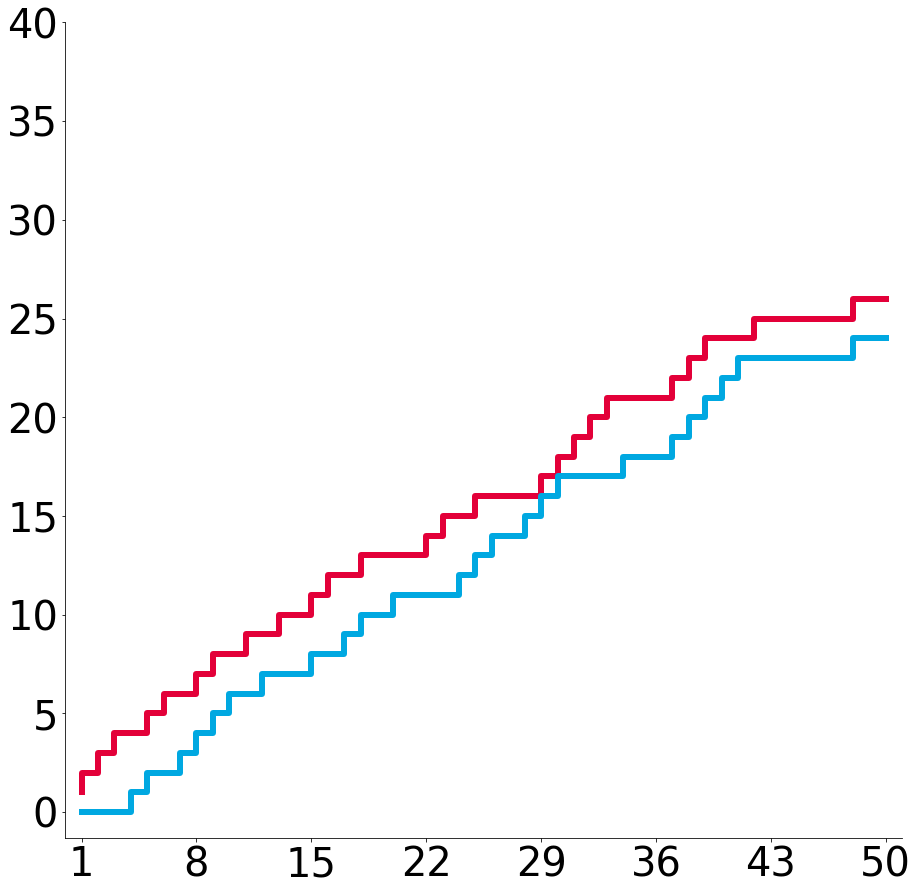

../result/Fig_comparison_DISEASES/AD_top_50.png save done.


In [248]:

fig_save_file = f'{fig_save_path}/fig_name.png'

x = np.linspace(1, 50, 50)

y_emfas = np.array(y_emfas)
y_gwas = np.array(y_gwas)

font_size = 40

fig, ax = plt.subplots(figsize=(15, 15))

emfas_line, = ax.step(x, y_emfas, color='#e30039', where='pre', lw=6)
gwas_line, = ax.step(x, y_gwas, color='#00a8e1', where='pre', lw=6)

ax.set_xlim(0, 51)
ax.set_xticks(np.arange(1, 51, 7))

ax.set_yticks(np.arange(0, 41, 5))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=font_size)

plt.savefig(fig_save_file, dpi=600)
plt.show()

print(f'{fig_save_file} save done.')

In [122]:
# 打印Top n 基因中分别有多少被这三类包含
top_n_compare_list = [50, 100, 1000]

print(f'EMFAS genes.')

print(f'Top-{top_n}, TexMining: {len(top_gene_set&textmining_gene_set)}, \
        Experiments: {len(top_gene_set&experiments_gene_set)}, \
        Knowledge: {len(top_gene_set&knowledge_gene_set)}, \
        Total: {len(top_gene_set&total_benchmark_gene_set)}')


for top_n_compare in top_n_compare_list:
    print(f'Top-{top_n_compare}, TexMining: {len(set(top_gene_list[:top_n_compare])&textmining_gene_set)}, \
            Experiments: {len(set(top_gene_list[:top_n_compare])&experiments_gene_set)}, \
            Knowledge: {len(set(top_gene_list[:top_n_compare])&knowledge_gene_set)}, \
            Total: {len(set(top_gene_list[:top_n_compare])&total_benchmark_gene_set)}')


EMFAS genes.
Top-3288, TexMining: 201,         Experiments: 126,         Knowledge: 21,         Total: 297
Top-50, TexMining: 24,             Experiments: 13,             Knowledge: 10,             Total: 26
Top-100, TexMining: 35,             Experiments: 18,             Knowledge: 12,             Total: 38
Top-1000, TexMining: 118,             Experiments: 49,             Knowledge: 18,             Total: 142


In [123]:
gwas_top_entrez_list

# 打印Top n 基因来自于 Sequence Analysis中分别有多少被这三类包含

# AD
gwas_top_n = 149

top_n_compare_list = [50, 100, 1000]


print(f'Sequence Analysis genes.')

print(f'Top-{gwas_top_n}, TexMining: {len(set(gwas_top_entrez_list[:gwas_top_n])&textmining_gene_set)}, \
        Experiments: {len(set(gwas_top_entrez_list[:gwas_top_n])&experiments_gene_set)}, \
        Knowledge: {len(set(gwas_top_entrez_list[:gwas_top_n])&knowledge_gene_set)}, \
        Total: {len(set(gwas_top_entrez_list[:gwas_top_n])&total_benchmark_gene_set)}')

for top_n_compare in top_n_compare_list:
    print(f'Top-{top_n_compare}, TexMining: {len(set(gwas_top_entrez_list[:top_n_compare])&textmining_gene_set)}, \
            Experiments: {len(set(gwas_top_entrez_list[:top_n_compare])&experiments_gene_set)}, \
            Knowledge: {len(set(gwas_top_entrez_list[:top_n_compare])&knowledge_gene_set)}, \
            Total: {len(set(gwas_top_entrez_list[:top_n_compare])&total_benchmark_gene_set)}')


Sequence Analysis genes.
Top-149, TexMining: 8,         Experiments: 54,         Knowledge: 2,         Total: 56
Top-50, TexMining: 4,             Experiments: 22,             Knowledge: 0,             Total: 24
Top-100, TexMining: 7,             Experiments: 43,             Knowledge: 2,             Total: 45
Top-1000, TexMining: 23,             Experiments: 109,             Knowledge: 5,             Total: 123


In [48]:
print(f'Experiments MRR: {MRR_calculate(top_gene_list, experiments_gene_set):.6f}')
print(f'Knowledge MRR: {MRR_calculate(top_gene_list, knowledge_gene_set):.6f}')
print(f'Textmining MRR: {MRR_calculate(top_gene_list, textmining_gene_set):.6f}')
print(f'Total MRR: {MRR_calculate(top_gene_list, total_benchmark_gene_set):.6f}')

Experiments MRR: 0.003433
Knowledge MRR: 0.099491
Textmining MRR: 0.012776
Total MRR: 0.006702


In [49]:
print(f'Hit@5: {hit_calculate(top_gene_list, total_benchmark_gene_set, 5):.4f}')
print(f'Hit@10: {hit_calculate(top_gene_list, total_benchmark_gene_set, 10):.4f}')
print(f'Hit@20: {hit_calculate(top_gene_list, total_benchmark_gene_set, 20):.4f}')
print(f'Hit@50: {hit_calculate(top_gene_list, total_benchmark_gene_set, 50):.4f}')
print(f'Hit@100: {hit_calculate(top_gene_list, total_benchmark_gene_set, 100):.4f}')
print(f'Hit@3281: {hit_calculate(top_gene_list, total_benchmark_gene_set, 3281):.4f}')

Hit@5: 0.0149
Hit@10: 0.0297
Hit@20: 0.0483
Hit@50: 0.0967
Hit@100: 0.1413
Hit@3281: 1.0000


In [50]:
precision, recall = precision_recall_calculate(top_gene_list, total_benchmark_gene_set)
print(f'precision: {precision:.4f}, recall: {recall:.4f}')

precision: 0.0929, recall: 0.4654


/home/xzyao/.local/lib/python3.9/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/xzyao/.local/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


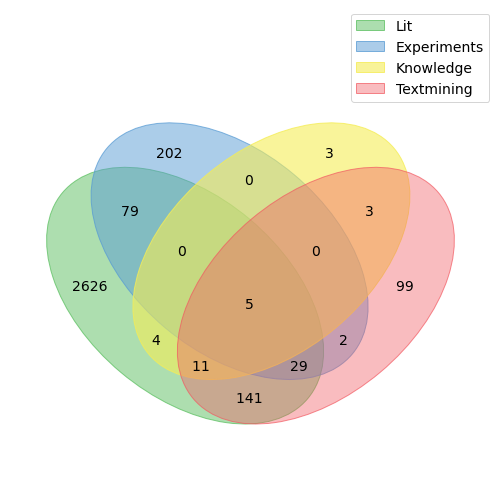

In [51]:
labels = venn.get_labels([top_gene_set, experiments_gene_set, knowledge_gene_set, textmining_gene_set],
                          fill=['number'])
fig, ax = venn.venn3(labels, names=['Lit', 'Experiments', 'Knowledge', 'Textmining'])
fig.show()